In [ ]:
import matplotlib.cm as cm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_images(directory):
    return [cv2.imread(file_) for file_ in glob.glob('data/*.jpg)')]


def resize_image(img,scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    return (width,height)

In [ ]:

def run_algorithm(product_image_path ,shelf_image_path,scale_shelf=False,scale_percent=0,encircle_width = 20):
    print("FIRST ARGUMENT : IMAGE OF THE PRODUCT \
           SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... ")

    img1 = cv2.imread("/content/drive/MyDrive/DataToKnowledge/data_/products"+product_image_path,0)
    img2  = cv2.imread("/content/drive/MyDrive/DataToKnowledge/data_/shelves"+shelf_image_path,0)

    ## RGB version of the images are used to show last result on colored one as requested.


    img1_rgb = cv2.imread("/content/drive/MyDrive/DataToKnowledge/data_/products"+product_image_path,1)
    img2_rgb = cv2.imread("/content/drive/MyDrive/DataToKnowledge/data_/shelves"+shelf_image_path,1)
    THRESHOLD_MATCH_COUNT = 10
    dim_img1 = resize_image(img1,500)
    dim_img2 = resize_image(img2,scale_percent)

    if scale_shelf==True:
        img2 = cv2.resize(img2,dim_img2,interpolation=cv2.INTER_AREA)
        img2_rgb=cv2.resize(img2_rgb,dim_img2,interpolation=cv2.INTER_AREA)

    img1 = cv2.resize(img1, dim_img1, interpolation = cv2.INTER_AREA)
    img1_rgb=cv2.resize(img1_rgb, dim_img1, interpolation = cv2.INTER_AREA)

    #     Initiate SIFT detector, in upgraded versions of OpenCV this function is patented and not free
    sift = cv2.xfeatures2d.SIFT_create()


    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    # for m in good:
    #   print(m.queryIdx)
    ## Eliminating not good matches by defining threshold
    if len(good)>THRESHOLD_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
    #     polyline_params = dict(isClosed=True,
    #                        color=(255,0,0),
    #                        thickness=10,
    #                        lineType=cv2.LINE_AA,
    #                        shift=0)
    #     img2 = cv2.polylines(img2,[np.int32(dst)],True,(0, 255 ,0),4, cv2.LINE_AA)


    else:
        print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None

    ## Defining parameters of draw funciton for insterest points of both image


    # src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    # dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # # Estimate homography matrix using all matches
    # M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    # matchesMask = mask.ravel().tolist()

    # # Apply perspective transform using the homography matrix to get the new points
    # h, w = img1.shape[:2]
    # pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    # dst = cv2.perspectiveTransform(pts, M)




    draw_params = dict(matchColor = (0,255,0,0), # draw matches in green color
                       singlePointColor =None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)


    plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
    matched_image = cv2.drawMatches(img1_rgb,kp1,img2_rgb,kp2,good,None,**draw_params)

    ## Here, we are encircling the search image on target one.

    cv2.line(matched_image, (int(dst[0,0,0] + img1.shape[1]), int(dst[0,0,1])),\
        (int(dst[1,0,0] + img1.shape[1]), int(dst[1,0,1])), (0,0,255), encircle_width)
    cv2.line(matched_image, (int(dst[1,0,0] + img1.shape[1]), int(dst[1,0,1])),\
        (int(dst[2,0,0] + img1.shape[1]), int(dst[2,0,1])), (0,0,255), encircle_width)
    cv2.line(matched_image, (int(dst[2,0,0] + img1.shape[1]), int(dst[2,0,1])),\
        (int(dst[3,0,0] + img1.shape[1]), int(dst[3,0,1])), (0,0,255), encircle_width)
    cv2.line(matched_image, (int(dst[3,0,0] + img1.shape[1]), int(dst[3,0,1])),\
            (int(dst[0,0,0] + img1.shape[1]), int(dst[0,0,1])), (0,0,255), encircle_width)

    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)),plt.show()
    # print(dst[0,0,0],dst[0,0,1],dst[1,0,0],dst[1,0,1])




    # Assuming img1 is the image on which the quadrilateral is drawn
    total_image_area = img2.shape[0] * img2.shape[1]

    # Coordinates of the quadrilateral
    quad_coords = [
        (int(dst[0, 0, 0] + img1.shape[1]), int(dst[0, 0, 1])),
        (int(dst[1, 0, 0] + img1.shape[1]), int(dst[1, 0, 1])),
        (int(dst[2, 0, 0] + img1.shape[1]), int(dst[2, 0, 1])),
        (int(dst[3, 0, 0] + img1.shape[1]), int(dst[3, 0, 1])),
    ]

    # Calculate the area of the quadrilateral using Shoelace formula
    quad_area = 0.5 * abs(
        (quad_coords[0][0] * (quad_coords[1][1] - quad_coords[3][1])) +
        (quad_coords[1][0] * (quad_coords[2][1] - quad_coords[0][1])) +
        (quad_coords[2][0] * (quad_coords[3][1] - quad_coords[1][1])) +
        (quad_coords[3][0] * (quad_coords[0][1] - quad_coords[2][1]))
    )
    # # cropped_image = img2[]
    # print(quad_coords)
    # cropped_image = [3715:4015, 148:649]
    # # print(img2.shape)
    # cv2_imshow(cropped_image)
    relative = np.array([[int(dst[0, 0, 0] + img1.shape[1]), int(dst[0, 0, 1])],
     [int(dst[1, 0, 0] + img1.shape[1]), int(dst[1, 0, 1])],
      [int(dst[2, 0, 0] + img1.shape[1]), int(dst[2, 0, 1])],
       [int(dst[3, 0, 0] + img1.shape[1]), int(dst[3, 0, 1])]])

    # Calculate the centroid of the matched region along the y-axis
    centroid_matched_y = np.mean(relative[:, 1])

    # Calculate the centroid of the entire image along the y-axis
    centroid_entire_image_y = img2.shape[0] / 2  # Assuming the y-axis is the vertical axis

    # Calculate the distance along the y-axis
    distance_y = abs(centroid_entire_image_y - centroid_matched_y)

    # Normalize the distance to a value between 0 and 1
    normalized_distance_y = distance_y / img2.shape[0]

    # The closer to 0, the more centrally located the matched region is along the y-axis
    print(f"The relative distance along the shelf height (y-axis) {normalized_distance_y:.2f}")

    if normalized_distance_y < 0.2:
      print("Offer more incentives to the shopkeeper for placing the product along the central shelf (along the customers eye level)")
      incentive = 0.25
    elif normalized_distance_y < 0.35 and normalized_distance_y > 0.2:
      print("Offer less incentives to the shopkeepr for placing the product not at the corners of the shelf but also not at the center.")
      incentive = 0.1
    else:
      print("Dont offer any inceentive to the shopkeeper. The product is not placed very well and is along the  corners.")
      incentive = 0
    # print(f"Incentive value = {incentive*100}%")



        # Calculate the percentage of area
    percentage_area = (quad_area / total_image_area) * 100

    print(f"The product occupies {percentage_area:.2f}% of the entire shelf image.")


    # quad_coords_np = np.array(quad_coords, dtype=np.int32)

    # # Create an empty mask for the region of interest (ROI)
    # mask = np.zeros_like(img2, dtype=np.uint8)

    # cv2.fillPoly(mask, [quad_coords_np], (255, 255, 255))  # Fill the polygon defined by quad_coords

    # # Convert the mask to a single-channel image
    # mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # # Find the contours in the mask
    # contours, _ = cv2.findContours(mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # # Find the bounding box of the non-zero region in the mask
    # x, y, w, h = cv2.boundingRect(contours[0])

    # # Crop the region of interest from the entire image
    # cropped_image = img2[y:y + h, x:x + w]

    # # Display or save the cropped image
    # cv2_imshow("Cropped Image", cropped_image)



FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


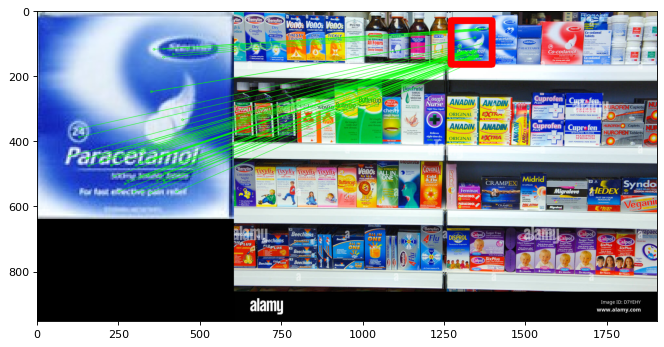

The relative distance along the shelf height (y-axis) 0.40
Dont offer any inceentive to the shopkeeper. The product is not placed very well and is along the  corners.
The product occupies 1.36% of the entire shelf image.


In [ ]:
run_algorithm('/test_product5.jpg','/test_shelf4.jpg')

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


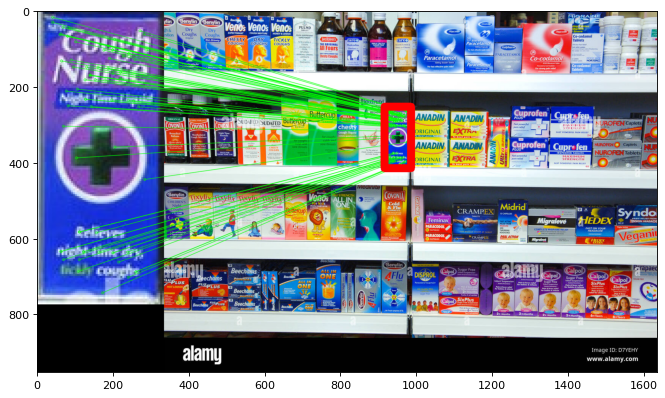

The relative distance along the shelf height (y-axis) 0.15
Offer more incentives to the shopkeeper for placing the product along the central shelf (along the customers eye level)
The product occupies 0.92% of the entire shelf image.


In [ ]:
run_algorithm('/test_product6.jpg','/test_shelf4.jpg')

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


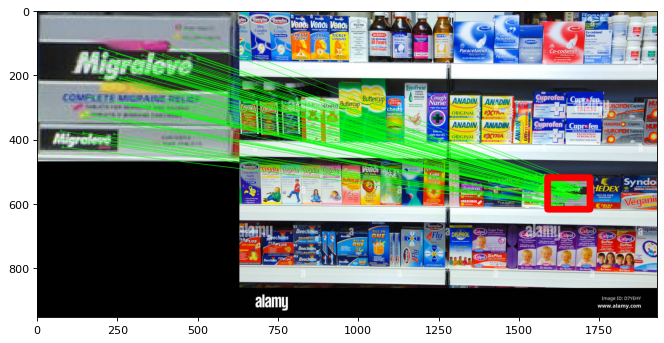

The relative distance along the shelf height (y-axis) 0.10
Offer more incentives to the shopkeeper for placing the product along the central shelf (along the customers eye level)
The product occupies 1.04% of the entire shelf image.


In [ ]:
run_algorithm('/test_product7.jpg','/test_shelf4.jpg')

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


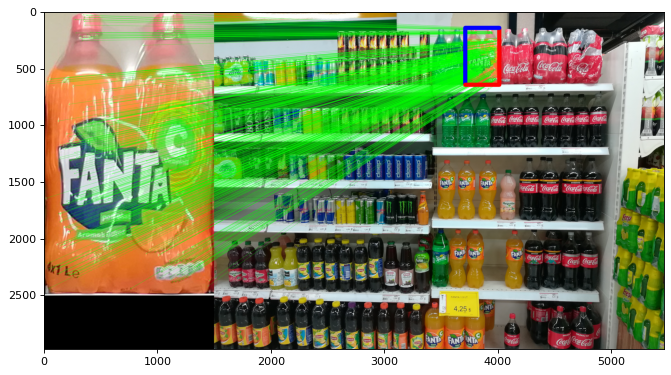

The relative distance along the shelf height (y-axis) 0.37
Offer less incentives to the shopkeepr for placing the product not at the corners of the shelf but also not at the center.
Incentive value = 10.0%
The product occupies 1.27% of the entire shelf image.


In [ ]:
run_algorithm('/c1_product.jpg','/c1_shelf.jpg')

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


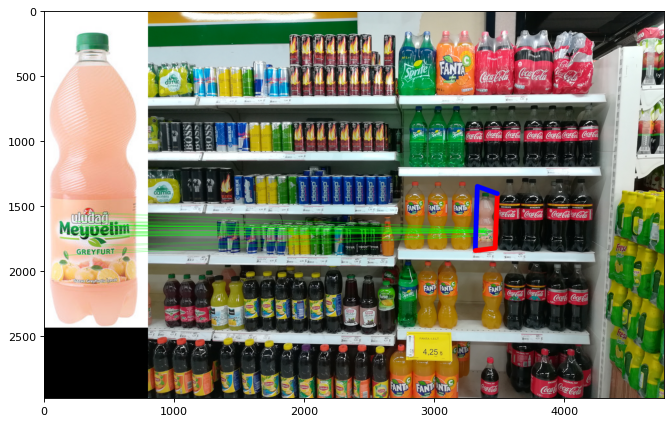

The relative distance along the shelf height (y-axis) 0.04
Offer more incentives to the shopkeeper for placing the product along the central shelf (along the customers eye level)
Incentive value = 25.0%
The product occupies 0.60% of the entire shelf image.


In [ ]:
run_algorithm('/c2_product.jpg','/c1_shelf.jpg')

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


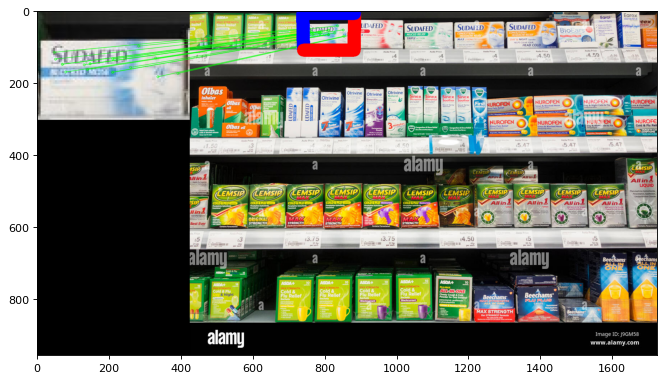

The relative distance along the shelf height (y-axis) 0.44
Dont offer any inceentive to the shopkeeper. The product is not placed very well and is along the  corners.
Incentive value = 0%
The product occupies 1.17% of the entire shelf image.


In [ ]:
run_algorithm('/test_product1.jpg','/test_shelf1.jpg')

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


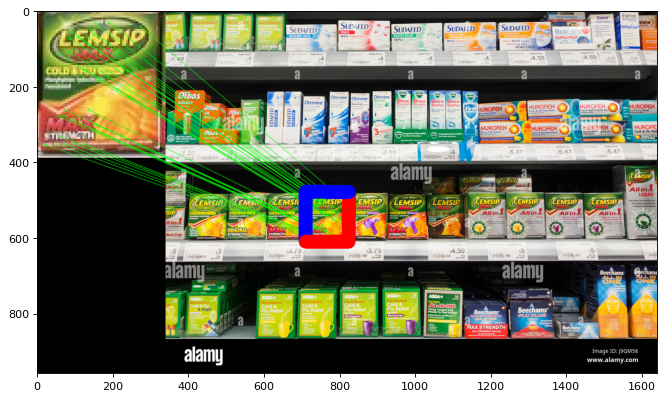

The relative distance along the shelf height (y-axis) 0.07
Offer more incentives to the shopkeeper for placing the product along the central shelf (along the customers eye level)
Incentive value = 25.0%
The product occupies 1.21% of the entire shelf image.


In [ ]:
run_algorithm('/test_product2.jpg','/test_shelf1.jpg')

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


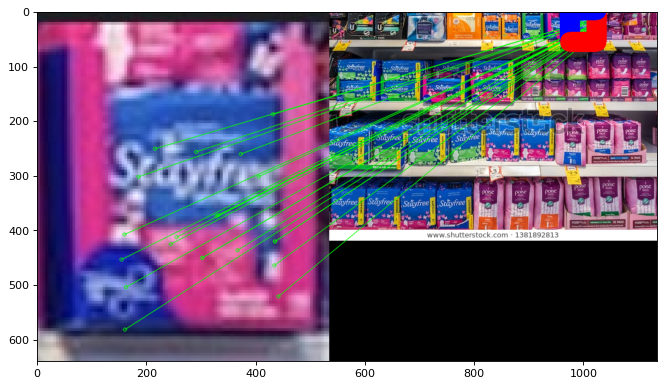

The relative distance along the shelf height (y-axis) 0.44
Dont offer any inceentive to the shopkeeper. The product is not placed very well and is along the  corners.
Incentive value = 0%
The product occupies 1.13% of the entire shelf image.


In [ ]:
run_algorithm('/test_product3.jpg','/test_shelf3.jpg')

In [ ]:
def light(shelf_image_path):
  image  = cv2.imread("/content/drive/MyDrive/DataToKnowledge/data_/shelves"+shelf_image_path,1)

  # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # average_intensity = cv2.mean(gray_image)[0]
  # _, thresholded_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

  # contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Extract the saturation channel
  saturation_channel = hsv_image[:,:,1]

  # Calculate the average saturation
  average_saturation = np.mean(saturation_channel)

  print(f"Average Saturation: {average_saturation}")

  # Set thresholds for different lighting conditions
  good_lighting_threshold = 50
  moderate_lighting_threshold = 30
  poor_lighting_threshold = 10

  # Determine lighting conditions
  if average_saturation > good_lighting_threshold:
      print("Good lighting conditions")
  elif average_saturation > moderate_lighting_threshold:
      print("Moderate lighting conditions")
  elif average_saturation > poor_lighting_threshold:
      print("Poor lighting conditions")
  else:
      print("Very poor lighting conditions")
  # plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB)),plt.show()

In [ ]:
light("/test_shelf3.jpg")

Average Saturation: 127.2234880952381
Good lighting conditions


In [ ]:
run_algorithm('/test_product3.jpg','/test_shelf3.jpg')